<a href="https://colab.research.google.com/github/karam-koujan/dog-vs-cat-classification/blob/main/feature_extraction_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle


In [ ]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mlrond","key":"fbae98785636cd498845ad590845bb9b"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/



In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 !kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          31924        871  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           3689        106  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           5923        126  1.0              
mohithsairamreddy/salary-data 

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:37<00:00, 24.5MB/s]
100% 812M/812M [00:37<00:00, 22.7MB/s]


In [ ]:
!unzip -qq dogs-vs-cats
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("dogs_vs_cats-small")


In [ ]:
def make_subset(subset_name,start_idx,end_idx):
    for category in ("cat","dog"):
       dir = new_base_dir / subset_name / category
       os.makedirs(dir)
       fnames = [f"{category}.{i}.jpg" for i in range(start_idx,end_idx)]
       for fname in fnames :
           shutil.copyfile(src=original_dir/fname,dst=dir/fname)
make_subset("train",0,1000)
make_subset("validation",1000,1500)
make_subset("test",1500,2500)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(new_base_dir/"train",image_size=(180,180),batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir/"validation",image_size=(180,180),batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir/"test",image_size=(180,180),batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
for data_batch, label_batch in train_dataset :
   print("data batch",data_batch.shape)
   print("label batch",label_batch.shape)
   break

data batch (32, 180, 180, 3)
label batch (32,)


In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
)
conv_base.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
conv_base.trainable_weights

[]



---





In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [ ]:

inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x - keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model = keras.Model(inputs,outputs)
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= "feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor= "val_loss"
    )
]
history = model.fit(train_dataset,epochs=50,validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 22s 224ms/step - loss: 33.6210 - accuracy: 0.8420 - val_loss: 5.2295 - val_accuracy: 0.9510
Epoch 2/50
63/63 [==============================] - 10s 147ms/step - loss: 13.1466 - accuracy: 0.9105 - val_loss: 18.3156 - val_accuracy: 0.9090
Epoch 3/50
63/63 [==============================] - 10s 153ms/step - loss: 11.5859 - accuracy: 0.9230 - val_loss: 6.9428 - val_accuracy: 0.9530
Epoch 4/50
63/63 [==============================] - 10s 157ms/step - loss: 8.5317 - accuracy: 0.9240 - val_loss: 7.3458 - val_accuracy: 0.9530
Epoch 5/50
63/63 [==============================] - 10s 160ms/step - loss: 6.3159 - accuracy: 0.9395 - val_loss: 9.5808 - val_accuracy: 0.9390
Epoch 6/50
63/63 [==============================] - 10s 153ms/step - loss: 6.1119 - accuracy: 0.9430 - val_loss: 6.5883 - val_accuracy: 0.9520
Epoch 7/50
63/63 [==============================] - 10s 150ms/step - loss: 6.0235 - accuracy: 0.9465 - val_loss: 9.0737 - val_accuracy: 0.

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss,test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc: .3f}, Test loss: {test_loss}")

63/63 [==============================] - 6s 94ms/step - loss: 1.1969 - accuracy: 0.9660
Test accuracy:  0.966, Test loss: 1.1968647241592407


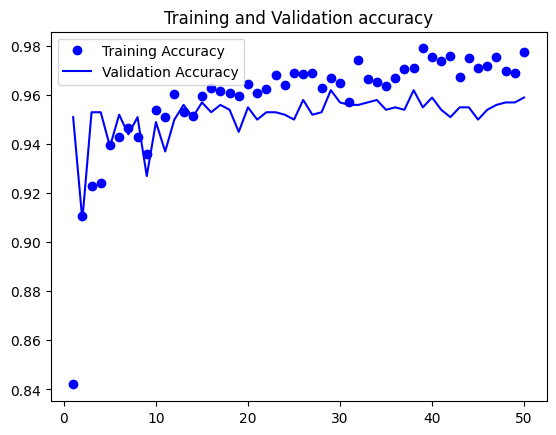

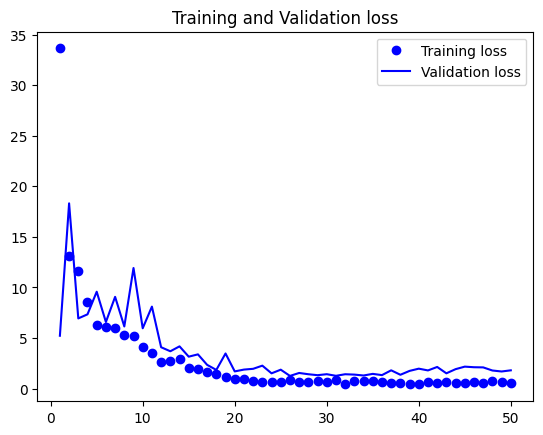

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,"bo",label="Training Accuracy")
plt.plot(epochs,val_accuracy,"b",label="Validation Accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs,loss,"bo",label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()
